In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import warnings
warnings.filterwarnings('ignore')

API_KEY = 'RIWOMQAIJJ40V284'

plt.style.use('seaborn')

In [2]:
def draw_candle(candle):
    x = candle.index[0]
    o = candle.values[0][0]
    h = candle.values[0][1]
    l = candle.values[0][2]
    c = candle.values[0][3]
    color = 'green' if o <= c else 'red'
    plt.plot([x, x], [h, l], color=color, linewidth=1)
    plt.plot([x, x], [o, c], color=color, linewidth=4)
    plt.xticks(rotation='vertical')

def draw_hist(candle):
    x = candle.index[0]
    h = candle.values[0][9]
    color = '#88ff88' if h >= 0 else '#ff8888'
    plt.plot([x, x], [0, h], color=color, linewidth=4)
    plt.xticks(rotation='vertical')

In [3]:
sym = 'SBER'
http = urllib3.PoolManager()
r = http.request('GET',
                 'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords=' + sym + '&apikey=' + API_KEY)
df = pd.DataFrame.from_dict(json.loads(r.data)['bestMatches'])
df

,1. symbol,2. name,3. type,4. region,5. marketOpen,6. marketClose,7. timezone,8. currency,9. matchScore
0,SBRCY,Sberbank of Russia,Equity,United States,09:30,16:00,UTC-05,USD,0.7273
1,SBER.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.7273
2,SBER.ILN,SBERBANK OF RUSSIA ADR (EACH RE,Equity,United Kingdom,08:00,16:30,UTC+01,GBP,0.6667
3,SBNC.FRK,Sberbank of Russia,Equity,Frankfurt,08:00,20:00,UTC+02,EUR,0.6667
4,SBERP.MOS,Sberbank of Russia,Equity,Moscow,10:00,18:45,UTC+03,RUB,0.5455
5,SBNC.STG,Sberbank of Russia PJSC Reg.Shs,Equity,Stuttgart,08:00,20:00,UTC+02,EUR,0.4000
6,SBNC.BER,SBERBANK ADR REGS/4 RL3,Equity,Berlin,08:00,20:00,UTC+02,EUR,0.3636
7,RU000A0ZZ5R2.MOS,PIF SberbankArendBiznes3,Mutual Fund,Moscow,10:00,18:45,UTC+03,RUB,0.2857


In [52]:
sym = 'SBER.MOS'
http = urllib3.PoolManager()
r = http.request('GET', 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + sym +
                 '&outputsize=full&apikey=' + API_KEY)

In [53]:
data = pd.DataFrame.from_dict(json.loads(r.data)['Time Series (Daily)'], orient='index', dtype=float)
data.rename(lambda x: x.split('. ')[1], axis='columns', inplace=True)
data.drop(data[data.open==0].index, axis=0, inplace=True)

In [54]:
data['fast'] = data.close.ewm(span=12, adjust=False).mean()
data['slow'] = data.close.ewm(span=26, adjust=False).mean()
data['macd'] = data.fast - data.slow
data['signal'] = data.macd.ewm(span=9, adjust=False).mean()
data['hist'] = data.macd - data.signal

In [55]:
data.head()

,open,high,low,close,volume,fast,slow,macd,signal,hist
2011-11-21,79.00,79.37,75.85,75.99,293803296.0,75.990000,75.990000,0.000000,0.000000,0.000000
2011-11-22,76.94,77.76,75.10,76.40,272599360.0,76.053077,76.020370,0.032707,0.006541,0.026165
2011-11-23,75.00,77.44,74.42,76.80,335403040.0,76.167988,76.078121,0.089867,0.023207,0.066661
2011-11-24,76.73,77.29,73.82,73.82,177337888.0,75.806759,75.910853,-0.104093,-0.002253,-0.101840
2011-11-25,75.40,78.75,73.75,78.27,319155936.0,76.185719,76.085604,0.100115,0.018220,0.081895


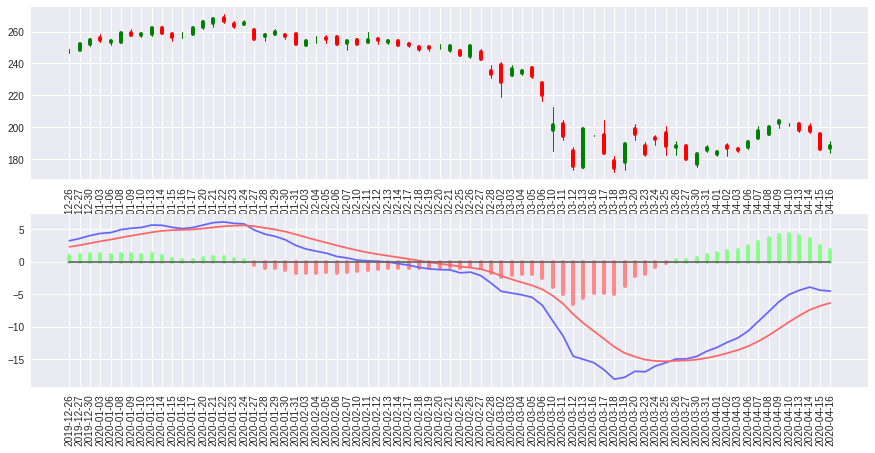

In [56]:
start, end = data.shape[0]-75, data.shape[0]

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
for i in range(start, end):
    draw_candle(data[i:i+1])

plt.subplot(2, 1, 2)
for i in range(start, end):
    draw_hist(data[i:i+1])
plt.plot(data.index[start:end], data.macd[start:end], color='#6666ff')
plt.plot(data.index[start:end], data.signal[start:end], color='#ff6666') 
plt.plot(data.index[start:end], np.zeros(end-start), color='#666666')


In [57]:
ingame = False
deals = []
enter = 0
exit = 0
for i in range(847, data.shape[0]):
    if data['hist'][i - 1] > 0 and data['hist'][i - 2] <= 0 and not ingame:
        enter = data['open'][i]
        ingame = True
    if data['hist'][i - 1] < 0 and ingame:
        exit = data['open'][i]
        deals.append([enter, exit])
        ingame = False

In [58]:
deals = pd.DataFrame(deals, columns=['enter', 'exit'])

In [59]:
deals['profit'] = (deals.exit - deals.enter) / deals.enter
deals['total'] = 1 + (deals.exit - deals.enter) / deals.enter

In [61]:
x = 10000
print('Since {}\nStart cash: {}'.format(data.index[847], x))
print('Without capitalization: {:>10}'.format(round((deals.profit.values * x).sum() + x, 2)))
print('With capitalization: {:>13}'.format(round(deals.total.values.prod() * x, 2)))

Since 2015-04-16
Start cash: 10000
Without capitalization:   18381.14
With capitalization:       21510.9


In [62]:
x = 10000
for d in deals.total:
    x *= d
    print('{:>5.2f} {:>8.2f}'.format(d, x))

 0.94  9414.81
 0.94  8821.21
 0.97  8566.97
 1.00  8524.31
 1.15  9824.02
 0.99  9772.75
 1.01  9841.21
 1.12 11015.75
 0.97 10654.67
 1.04 11035.36
 0.96 10639.62
 0.97 10329.44
 0.99 10233.18
 1.04 10633.36
 0.98 10399.22
 1.11 11541.09
 0.99 11409.68
 0.96 10959.84
 1.04 11348.33
 1.18 13424.71
 1.04 13951.00
 1.11 15444.66
 1.04 16100.23
 1.03 16504.24
 1.01 16681.17
 1.00 16611.01
 0.99 16426.80
 0.94 15454.73
 1.01 15621.81
 1.00 15620.99
 0.99 15485.29
 1.10 16967.97
 1.13 19101.22
 0.99 18832.42
 1.01 18990.11
 1.03 19533.42
 1.04 20223.01
 0.98 19904.70
 1.08 21510.90


In [63]:
deals.profit.mean() / deals.profit.std()

0.3587962384245113